Yaniv Cohen - 066484296

Eran Ben Artzy - 204041982

#***Heart failure clinical records Data Set***

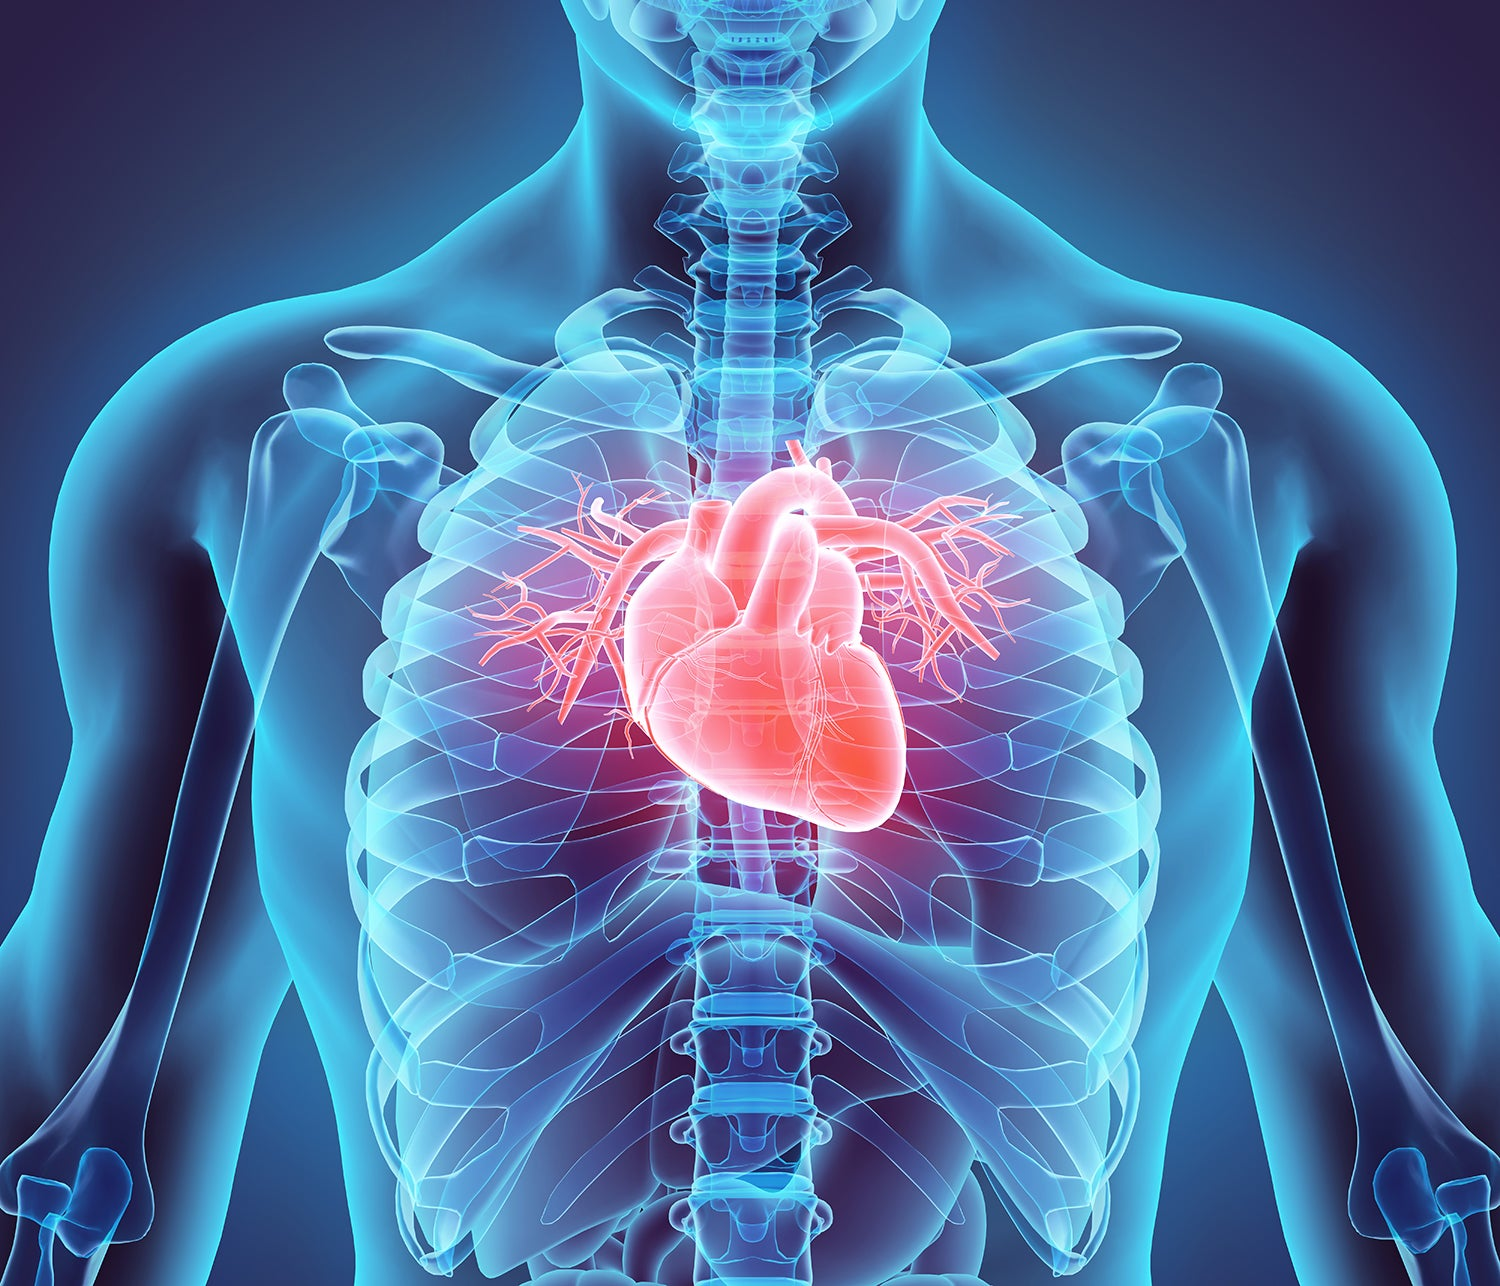


# Imports

Here are listed the main libraries used:


*   Numpy: standard library for math operations on arrays
*   Pandas: used to manipulate data inside dataframes and for basic computations
*   Sklearn: used to apply different ML algorithms/models to the data
*   Matplotlib: to plot visualizations
*   Seaborn: built on top of pyplot for nicer visualizations


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score , classification_report
from sklearn.pipeline import Pipeline
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('heart_failure.csv')

# Dataset
This dataset contains the medical records of 299 patients who had heart failure, collected during their follow-up period, where each patient profile has 13 clinical features.


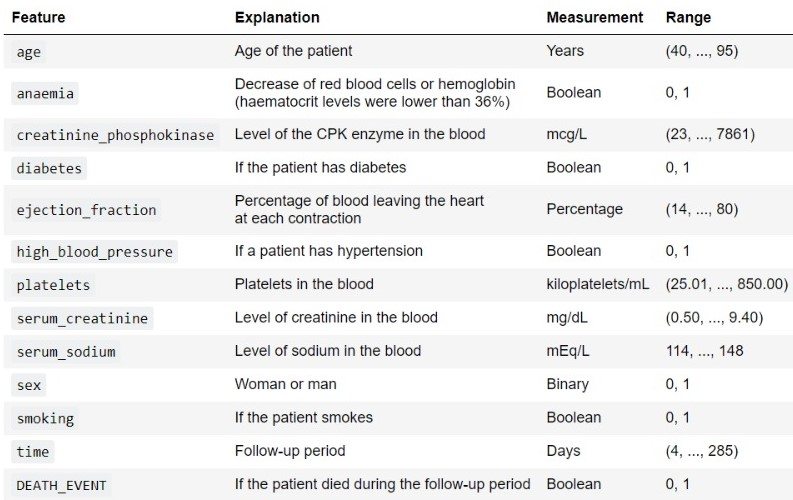

Quick impression of the data set:

In [ ]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [ ]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


We can see plateles is multiplied by 1000 so we'll adjust it according to our dictionary

In [ ]:
df.platelets = df.platelets/1000

In [ ]:
df.platelets.describe()

count    299.000000
mean     263.358029
std       97.804237
min       25.100000
25%      212.500000
50%      262.000000
75%      303.500000
max      850.000000
Name: platelets, dtype: float64

We can also see that serum sodium has values below 114 (which is the minimum in our dictionary) so we'll drop them.

In [ ]:
df = df[df.serum_sodium >= 114]

In [ ]:
df.serum_sodium.describe()

count    298.000000
mean     136.704698
std        4.201176
min      116.000000
25%      134.000000
50%      137.000000
75%      140.000000
max      148.000000
Name: serum_sodium, dtype: float64

In [ ]:
target = 'DEATH_EVENT'
boolean_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
numerical_features = list(set(df._get_numeric_data().columns)-set([target])-set(boolean_features))
categorical_features = list(set(df.columns)-set(numerical_features)-set([target]))
print(f'numerical features: {numerical_features}')
print(f'categorical features: {categorical_features}')

numerical features: ['serum_creatinine', 'ejection_fraction', 'serum_sodium', 'creatinine_phosphokinase', 'platelets', 'age', 'time']
categorical features: ['sex', 'high_blood_pressure', 'smoking', 'anaemia', 'diabetes']


# Outliers Detection

based on Tukey method (Tukey JW., 1977)


In [ ]:
from collections import Counter

def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers  


rows_with_more_than_1_outlier = detect_outliers(df, 1 ,numerical_features)

Since outliers can have a dramatic effect on the prediction (espacially for regression problems), we chose to manage them.

we used the Tukey method (Tukey JW., 1977) to detect ouliers which defines an interquartile range comprised between the 1st and the 3rd quartile of the distribution values (IQR). 

An outlier is a row that have a feature value outside the of (IQR +- an outlier step).

In [ ]:
df.loc[rows_with_more_than_1_outlier]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
4,65.0,1,160,1,20,0,327.00000,2.7,116,0,0,8,1
38,60.0,0,2656,1,30,0,305.00000,2.3,137,1,0,30,0
52,60.0,0,3964,1,62,0,263.35803,6.8,146,0,0,43,1
117,85.0,1,102,0,60,0,507.00000,3.2,138,0,0,94,0
167,59.0,0,66,1,20,0,70.00000,2.4,134,1,0,135,1
217,54.0,1,427,0,70,1,151.00000,9.0,137,0,0,196,1
281,70.0,0,582,0,40,0,51.00000,2.7,136,1,1,250,0
200,63.0,1,1767,0,45,0,73.00000,0.7,137,1,0,186,0
296,45.0,0,2060,1,60,0,742.00000,0.8,138,0,0,278,0


Only a few rows with more than 1 outlier were detected using the IQR so we'll delete them

In [ ]:
df = df.drop(rows_with_more_than_1_outlier, axis=0).reset_index(drop=True)
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265.00000,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263.35803,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162.00000,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210.00000,1.9,137,1,0,7,1
4,90.0,1,47,0,40,1,204.00000,2.1,132,1,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,63.0,1,103,1,35,0,179.00000,0.9,136,1,1,270,0
285,62.0,0,61,1,38,1,155.00000,1.1,143,1,1,270,0
286,55.0,0,1820,0,38,0,270.00000,1.2,139,0,0,271,0
287,45.0,0,2413,0,38,0,140.00000,1.4,140,1,1,280,0


We can see that now we have only 289 rows instead of 299 rows

# Missing Values

In [ ]:
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

No data is missing.

# Correlation matrix

correlation matrix is simply a table which displays the linear relationships between each tuple of features.


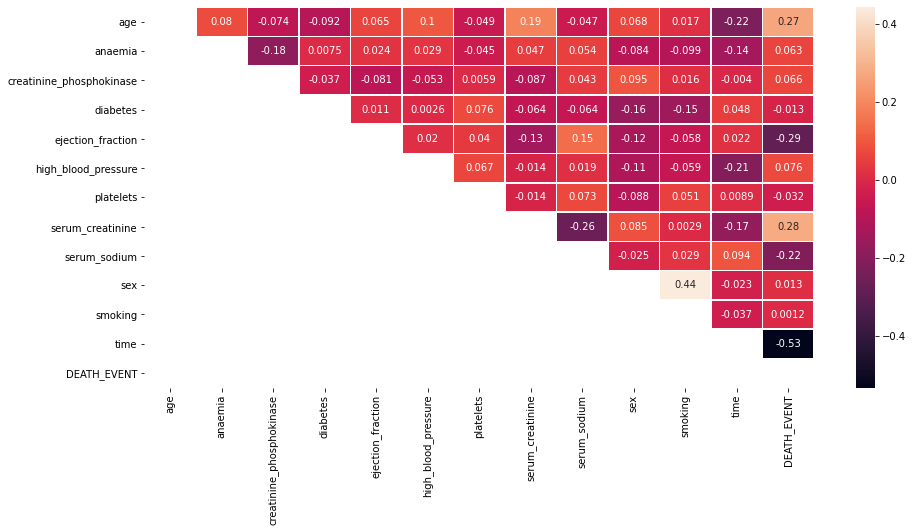

In [ ]:
corr= df.corr()
matrix = np.tril(corr)
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(corr, annot=True, mask=matrix, linewidths=.5, ax=ax);

We can see that there's a positive linear relationship between sex & smoking (0.44).

We can also see a positive linear relationship between serum_creatinine, serum_sodium to DEATH_EVENT.

Also, we have a negative linear relationship between ejection_fraction to DEATH_EVENT.


# Feature distributions

In [ ]:
# skewness along the index axis
df.skew(axis = 0, skipna = True)

age                         0.420392
anaemia                     0.273811
creatinine_phosphokinase    4.785768
diabetes                    0.360442
ejection_fraction           0.548999
high_blood_pressure         0.587010
platelets                   1.396723
serum_creatinine            4.640507
serum_sodium               -0.379035
sex                        -0.650762
smoking                     0.749900
time                        0.133241
DEATH_EVENT                 0.784017
dtype: float64

We can see the skewness of every feature in such a way that positive numbers indicate we have a right tale, and negative numbers indicate we have a left tale.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions

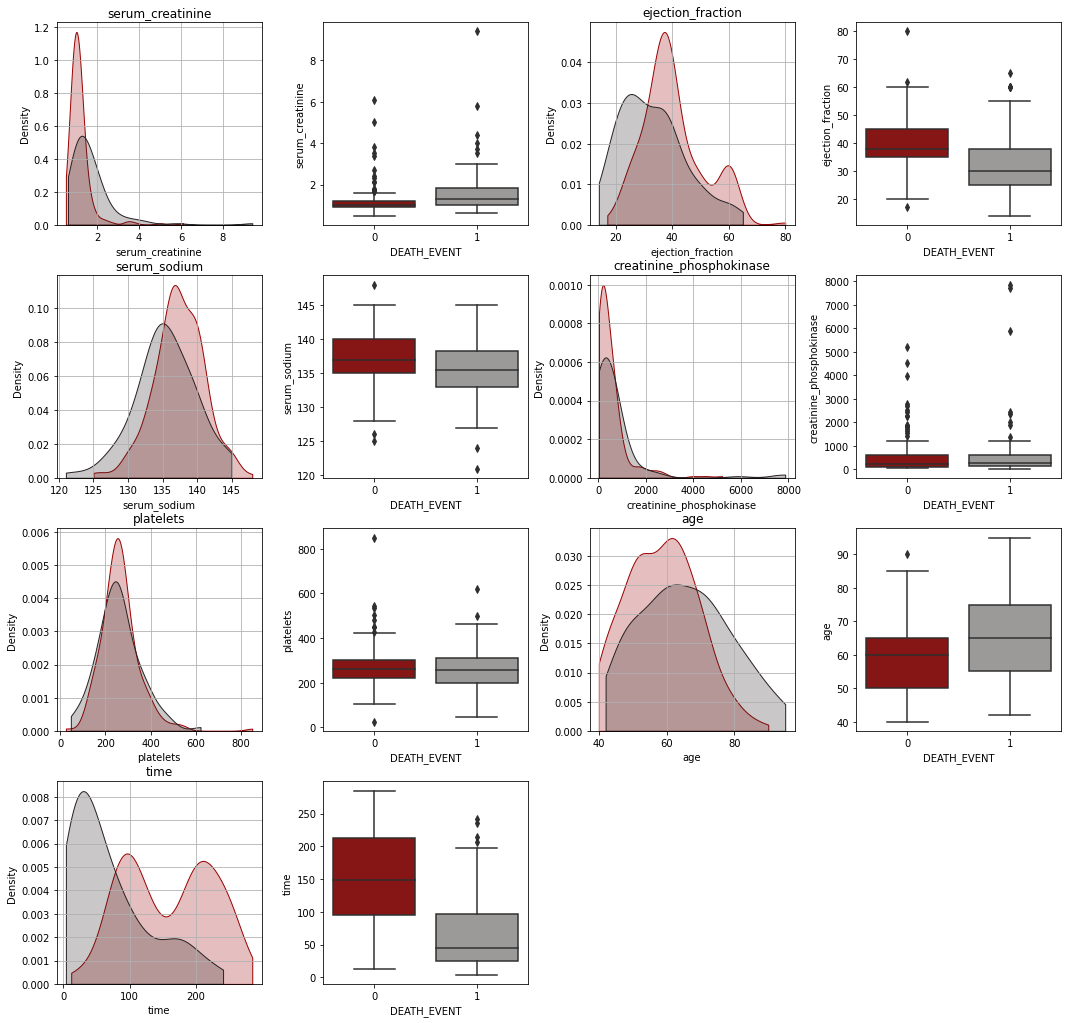

In [ ]:
plt.figure(figsize=(18, 27))

for i, col in enumerate(numerical_features):
    plt.subplot(6, 4, i*2+1)
    plt.subplots_adjust(hspace =.25, wspace=.3)
    plt.grid(True)
    plt.title(col)
    sns.kdeplot(df.loc[df[target]==0, col], label="alive", color = "#990303", shade=True, kernel='gau', cut=0)
    sns.kdeplot(df.loc[df[target]==1, col], label="dead",  color = "#292323", shade=True, kernel='gau', cut=0)
    plt.subplot(6, 4, i*2+2)
    sns.boxplot(y = col, data = df, x=target, palette = ["#990303", "#9C9999"])   

A report of the categorical features:

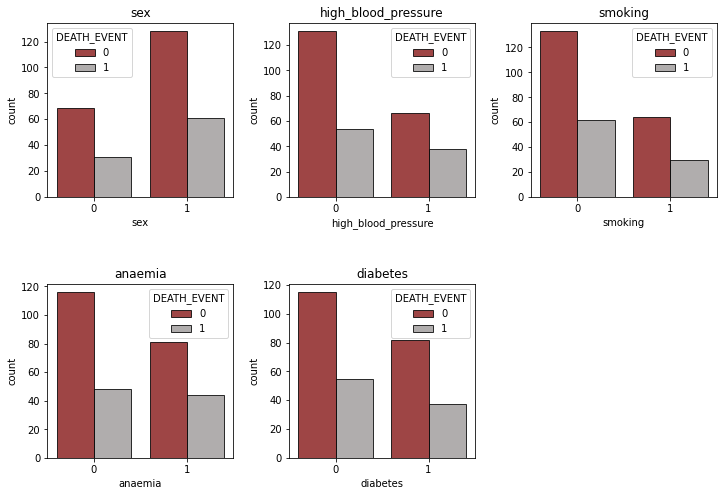

In [ ]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(categorical_features):
    plt.subplot(2, 3, i+1)
    plt.title(col)
    plt.subplots_adjust(hspace =.5, wspace=.3)
    sns.countplot(data=df, x=col, hue=target, palette = ["#990303", "#9C9999"], alpha=0.8, edgecolor="k", linewidth=1)

We can see above the boolean features that affect the DEATH_EVENT.
 
sex:
The percentage of dead men (out of all men) is ~33%, and the percentage of dead women (out of all women) is also ~33%.
The conclusion is that sex does NOT affect DEATH_EVENT.

high_blood_pressure: 
The percentage of dead high blood pressure people (out of all high blood pressure people) is ~40%, and the percentage of dead normal blood pressure people (out of all normal blood pressure people) is ~30%.
The conclusion is that high_blood_pressure DOES affect DEATH_EVENT.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


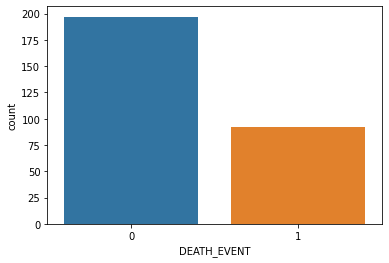

In [ ]:
sns.countplot(df[target]);

So we need to balance the data - we'll do it using SMOTE which is the most popular way of balancing an imbalanced dataset.



In [ ]:
X = df.drop(columns=target)
y = df[target]

# Reduce skewness distribution**


In [ ]:
def show_CPK_skewness():
  g = sns.distplot(X["creatinine_phosphokinase"], 
                   color="b", 
                   label="Skewness : %.2f"%(X["creatinine_phosphokinase"].skew()))
  g = g.legend(loc="best")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


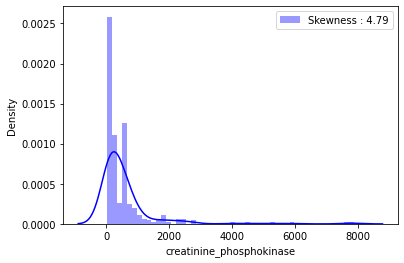

In [ ]:
show_CPK_skewness()

Apply log to reduce skewness distribution

In [ ]:
# Apply log to reduce skewness distribution
X["creatinine_phosphokinase"] = X["creatinine_phosphokinase"].map(lambda i: np.log(i) if i > 0 else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


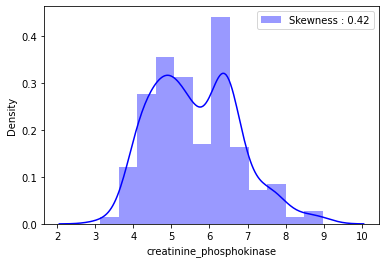

In [ ]:
show_CPK_skewness()

In [ ]:
def show_serum_skewness():
  g = sns.distplot(X["serum_creatinine"], 
                   color="b", 
                   label="Skewness : %.2f"%(X["serum_creatinine"].skew()))
  g = g.legend(loc="best")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


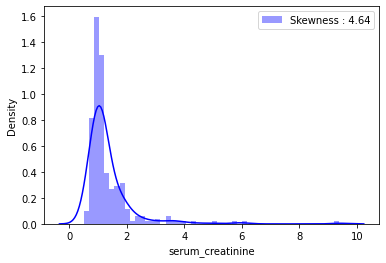

In [ ]:
show_serum_skewness()

In [ ]:
# Apply log to reduce skewness distribution
X["serum_creatinine"] = X["serum_creatinine"].map(lambda i: np.log(i) if i > 0 else 0)

Let's take a look on the balanced creatine_phosphokinase and serum_creatinine features:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


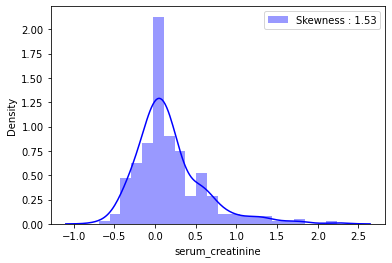

In [ ]:
show_serum_skewness()

**Normalization**

We want to normalize the data because it will give us insights about which features are the most important for the regression, because the bigger the coefficient (weight) the more important the feature.

Without normalization, we would assume by mistake a big importance to a not important feature and a small importance to an important feature.

Also, it doesn't harm the accuracy of the decision tree.

We'll use MinMaxScaler which for each value in a feature, will subtract the minimum value in the feature and then divide it by the range. 

The range is the difference between the original maximum and original minimum. 

MinMaxScaler preserves the shape of the original distribution.




In [ ]:
min_max_scaler = MinMaxScaler()
original_columns = X.columns
X = X.reset_index(drop=True)
X =  min_max_scaler.fit_transform(X)
X = pd.DataFrame(X, columns=original_columns)

exectuing train_test_split in the right timing!

In [ ]:
X, X_outsample, y, y_outsample = train_test_split(X, y, test_size=0.2)

# SMOTE

SMOTE works by utilizing a k-nearest neighbor algorithm to create synthetic data. 

SMOTE first start by choosing random data from the minority class, then k-nearest neighbors from the data are set. 

Synthetic data would then made between the random data and the randomly selected k-nearest neighbor.

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=2021, n_jobs=-1, k_neighbors=5)

X_smote, y_smote = smote.fit_resample(X, y)

X = pd.DataFrame(X_smote,columns=X.columns)
y = y_smote


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


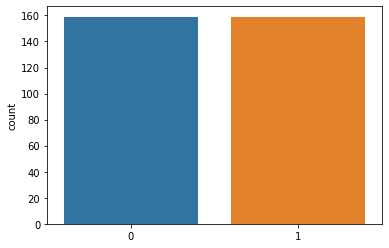

In [ ]:
sns.countplot(y)

Now we can see the data is balanced so SMOTE worked!

**Feature importance of tree based classifiers**

In order to see the most informative features for the prediction of patients survival, we displayed the feature importance for the upcoming trees.

In [ ]:
DTC = DecisionTreeClassifier(criterion='gini',random_state=0).fit(X, y)

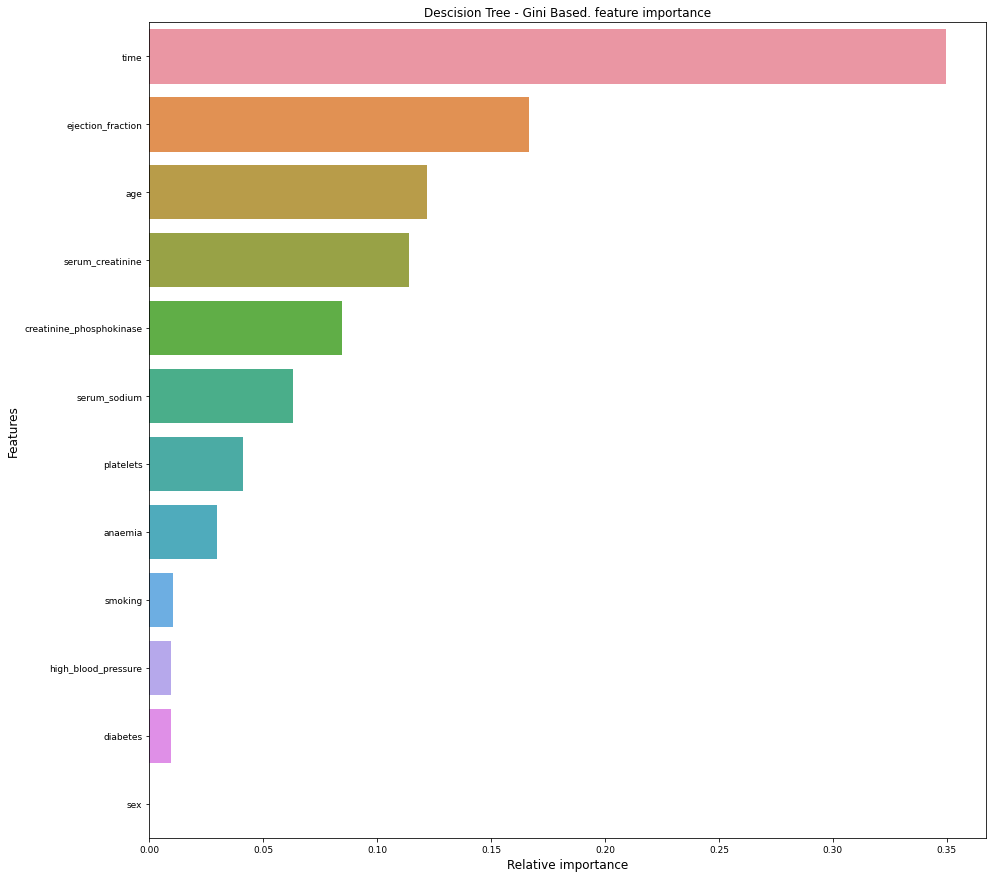

In [ ]:
nrows = ncols = 1 
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15),squeeze=False)
names_classifiers = [("Descision Tree - Gini Based.", DTC)] #<---you can add to that list more tree models

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:13]
        g = sns.barplot(y=X.columns[indices][:13],
                        x = classifier.feature_importances_[indices][:13] , 
                        orient='h',
                        ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

We will run the decision tree algorithm later again but will filter out unimportant attributes.

# Hyperparameter tunning for best models(just 2 for now)**



**Desicion tree model:**
  let's find first the max_depth for the Decision tree

In [ ]:
important_features_DTC = ["creatinine_phosphokinase", "ejection_fraction", "time"]

In [ ]:
criterion = ['gini', 'entropy'] 
max_depth = [2, 4, 6, 8, 10, 12]

dec_tree = DecisionTreeClassifier()

pipe = Pipeline(steps=[('dec_tree', dec_tree)])
parameters = dict(dec_tree__criterion=criterion, dec_tree__max_depth=max_depth)
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X[important_features_DTC], y)

print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print(clf_GS.best_estimator_.get_params()['dec_tree'])


 

Best Criterion: gini
Best max_depth: 12
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=12, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


We found that  max_depth and best criterion

In [ ]:
max_depth = clf_GS.best_estimator_.get_params()['dec_tree__max_depth']
best_criterion = clf_GS.best_estimator_.get_params()['dec_tree__criterion']

Let's see the new Decision tree.

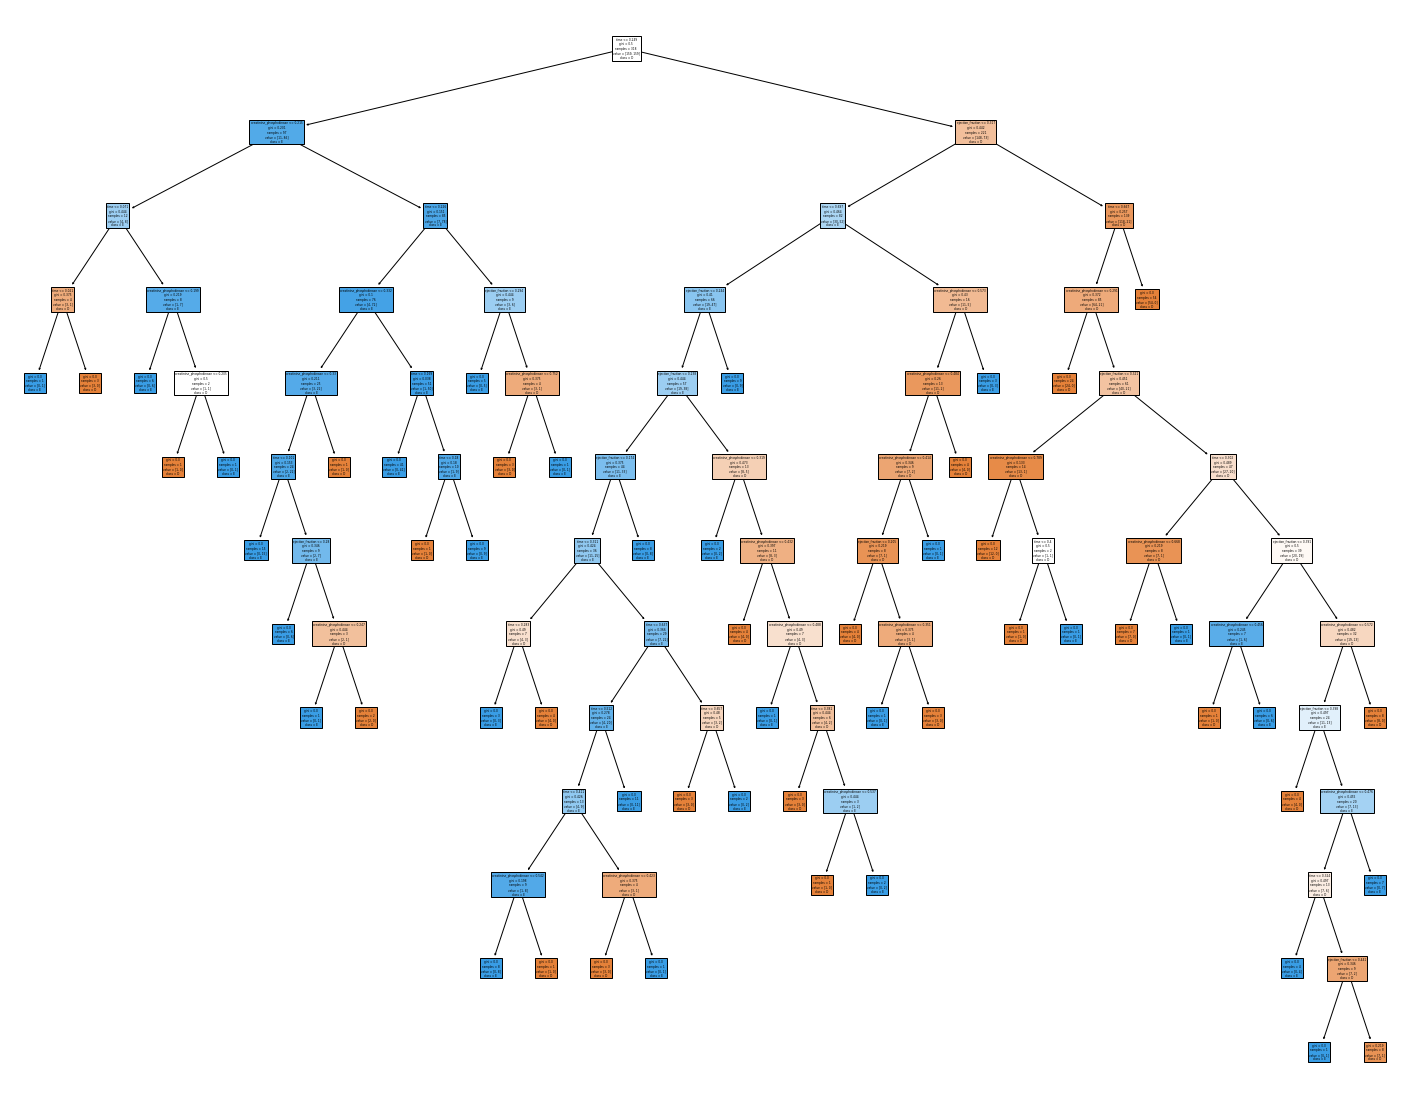

In [ ]:

DTC = DecisionTreeClassifier(criterion=best_criterion, max_depth = max_depth).fit(X[important_features_DTC], y)
y_outsample_pred = DTC.predict(X_outsample[important_features_DTC])


fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DTC, 
                   feature_names=X[important_features_DTC].columns,  
                   class_names=target,
                   filled=True)


# dot_data = tree.export_graphviz(DTC, 
#                                 feature_names=list(X_train[["creatinine_phosphokinase","ejection_fraction","time"]].columns),  
#                                 class_names=target,  
#                                 filled=True, 
#                                 rounded=True,  
#                                 special_characters=True,
#                                 out_file=None)

# graph = graphviz.Source(dot_data)
# graph.format = "png"
# graph.render("decision_tree_gini")

In [ ]:
print(f'Decision Tree Accuracy: {accuracy_score(y_outsample, y_outsample_pred)}')

Decision Tree Accuracy: 0.8103448275862069


Classification report for Decision Tree Model:

In [ ]:
print(classification_report(y_outsample, y_outsample_pred))

              precision    recall  f1-score   support

           0       0.91      0.79      0.85        38
           1       0.68      0.85      0.76        20

    accuracy                           0.81        58
   macro avg       0.79      0.82      0.80        58
weighted avg       0.83      0.81      0.81        58



**Logistic regresion model**: let's find the best HyperParameters.

**Best attributes to use for logistic regression  are** 'serum_creatinine', 'ejection_fraction','time','creatinine_phosphokinase' based on the corralation matrix above.



In [ ]:

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]} # l1 lasso l2 ridge
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg,grid,cv=10)
important_features_LR = ['serum_creatinine', 'ejection_fraction','time','creatinine_phosphokinase']
logreg_cv.fit(X[important_features_LR], y)

best_C = logreg_cv.best_params_['C']
best_penalty = logreg_cv.best_params_['penalty']

print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_se

tuned hpyerparameters :(best parameters)  {'C': 100.0, 'penalty': 'l2'}
accuracy : 0.7797379032258065


**tuned hpyerparameters** :(best parameters)  {'C': 100.0, 'penalty': 'l2'}

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

logistic = LogisticRegressionCV(Cs=4, fit_intercept=True, cv=10, verbose=1,random_state=42)
logistic.fit(X[important_features_LR], y)
y_outsample_pred = logistic.predict(X_outsample[important_features_LR])

print(f'Logistic regression Accuracy: {accuracy_score(y_outsample, y_outsample_pred)}')
print(logistic.coef_) # weights of each feature
print(logistic.intercept_) # value of intercept


Logistic regression Accuracy: 0.8448275862068966
[[ 6.20946638 -4.09876812 -5.42979252  2.31519349]]
[0.63590255]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


Classification report for Logistic regression:

In [ ]:
print(classification_report(y_outsample, y_outsample_pred))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87        38
           1       0.70      0.95      0.81        20

    accuracy                           0.84        58
   macro avg       0.84      0.87      0.84        58
weighted avg       0.88      0.84      0.85        58



**Cross validate models**

I compared the 2 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.

0.7952620967741936
0.7797379032258065


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


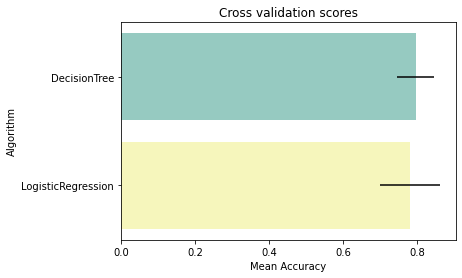

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(DecisionTreeClassifier(criterion = best_criterion ,
                                          max_depth= max_depth ,
                                          random_state=random_state))
classifiers.append(LogisticRegression(penalty = best_penalty, 
                                      C = best_C, 
                                      random_state = random_state))

cv_results = []
cv_results.append(cross_val_score(classifiers[0], X[important_features_DTC], y = y, scoring = "accuracy", cv = kfold, n_jobs=4))
cv_results.append(cross_val_score(classifiers[1],  X[important_features_LR], y = y, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    print(cv_result.mean())

cv_res = pd.DataFrame({"CrossValMeans":cv_means, "CrossValerrors": cv_std, "Algorithm":["DecisionTree","LogisticRegression"]})

g = sns.barplot("CrossValMeans", "Algorithm", data = cv_res, palette="Set3", orient = "h", **{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

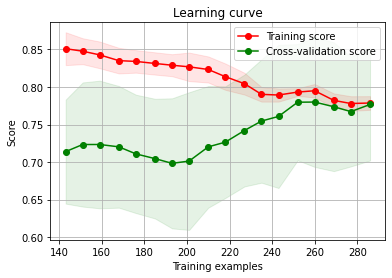

In [ ]:
from sklearn.model_selection import learning_curve

# Learning curve
def Learning_curve_model(X, Y, model, cv, train_sizes):

    plt.figure()
    plt.title("Learning curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, cv=cv, n_jobs=4, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, 
                    alpha=0.1,
                    color="r")
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, 
                     color="g")
    plt.plot(train_sizes, 
             train_scores_mean, 
             'o-', 
             color="r",
             label="Training score")
    plt.plot(train_sizes, 
             test_scores_mean, 
             'o-', 
             color="g",
             label="Cross-validation score")
                     
    plt.legend(loc="best")
    return plt


logreg  = LogisticRegression()
DTC = DecisionTreeClassifier()
cv = 10
train_size=np.linspace(.5, 1.0, 18)
Learning_curve_model(X[important_features_LR], y, logreg, cv, train_size)
# Learning_curve_model(X[important_features_DTC], y, DTC, cv,train_size)


A conclusion from the red graph of training on a single training set shows that the larger the set, the smaller the over-fit, and therefore the accuracy decreases, meaning that the score accuracy decreases gradually.
The green graph shows that the 10cross validation technique is really  effective, because it prevents overfitting already starting from a small set size so the green graph does not have a negative slope. 
This can be explained by the fact that the error estimation of this technique is with smaller bias and also with smaller variance, in simple words, the larger the "survey" (10 folds) the better the forecast.

**An important conclusion** from the chart: the more you increase the amount of data, the more accurate results you get for the regression model, but increasing the amount of data from a certain point (250) does not contribute to that anymore - you can see this by the converging of the two graphs to a horizontal asymptote.